# pytorch手把手實作: 物件偵測模型(1)-以TrafficSign為例
<br>
<font size=4> 
    
資料集: [kaggle的Road Sign Detection](https://www.kaggle.com/andrewmvd/road-sign-detection) <br>
<br>

我們這邊建立一個模型，用作直覺的方式進行物件偵測的模型訓練。<br>
假設模型可以偵測有B個物件框，整張圖最多偵測B個物件框。
    
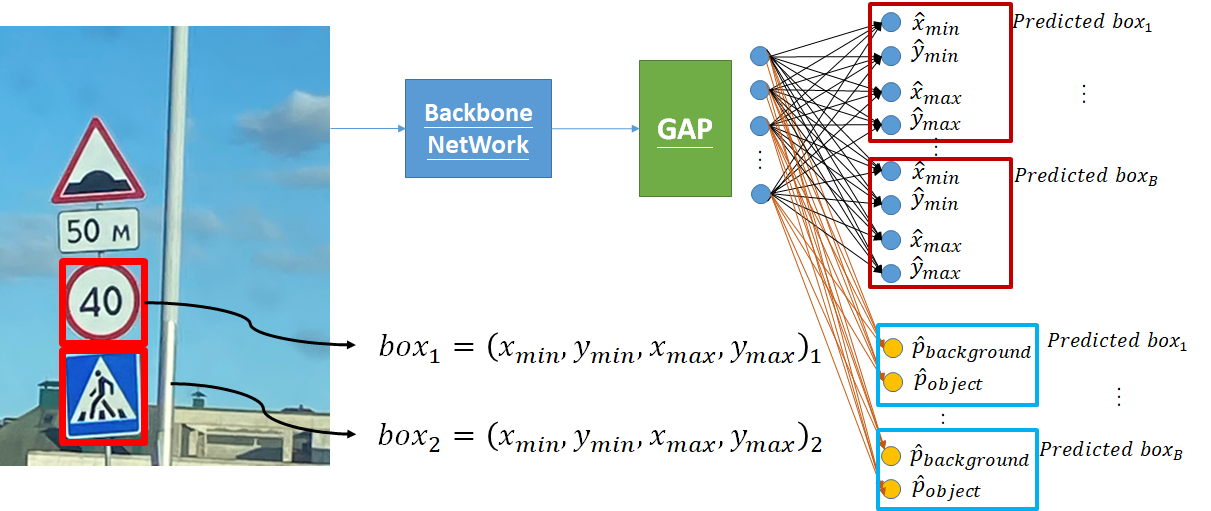


In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import random
import math
from datetime import datetime
from collections import Counter
import numpy as np
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torch
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

## 1. 資料庫讀取 (在13_Database_TrafficSign.ipynb)已經做過介紹

In [2]:

labelmap = {'background':0, 'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 4}
images_path = Path('./dataset/stopsign/images')
anno_path = Path('./dataset/stopsign/annotations')
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
def xml_parser(xml_path):
    root = ET.parse(xml_path).getroot()
    filename = Path(str(images_path) + '/' + root.find("./filename").text)
    bboxes=[]
    labels=[]
    for object_xml in root.iter('object'):
        label = object_xml.find('name').text.lower()
        bbox = object_xml.find('bndbox')
        xmin = int(bbox.find("xmin").text) 
        ymin = int(bbox.find("ymin").text) 
        xmax = int(bbox.find("xmax").text) 
        ymax = int(bbox.find("ymax").text) 
        bbox = [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
        labels.append(labelmap[label])
    return filename, bboxes, labels
def generate_data_inf(annotations):
    imagepaths = []
    bboxes = []
    for anno_path in annotations:
        filename, bboxs, labels = xml_parser(anno_path)
        imagepaths.append(filename)
        bboxes.append([labels,bboxs])
    return imagepaths, bboxes

annotations = filelist(anno_path, '.xml')
imagepaths, bboxes = generate_data_inf(annotations)


image shape:(400, 300, 3)
label:[3, 3]
bbox:[[91, 122, 141, 179], [157, 202, 172, 225]]


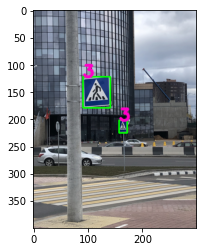

In [3]:
def plot_image_withbbox(img, bboxs, labels=[], flag_bgr=1):
    imageplot=img.copy()
    if len(labels)==0:
        for bb in bboxs:
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
    else:
        for bb, label in zip(bboxs,labels):
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
            cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 4, cv2.LINE_AA)
    if flag_bgr==1:
        plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
    else:
         plt.imshow(imageplot)
    plt.show()
    
data_id = 100
im = cv2.imread(str(imagepaths[data_id]))
bboxs = bboxes[data_id][1]
labels = bboxes[data_id][0]
print('image shape:{}'.format(im.shape))
print('label:{}'.format(labels))
print('bbox:{}'.format(bboxs))
plot_image_withbbox(im, bboxs, labels)

# 2. 模型架構

<br>
<font size=4> 
這邊我用RestNet18 + GAP + 1. Fully connection (class) + 2. Boundary Box <br>

模型輸出直接去預測物件框的位置($x_{min}, y_{min},x_{max}, y_{max}$)。(先不要考慮太多，後續才會介紹現今的物件偵測方法)
    
</font>
<br>
<br>

<font size=4> 
    
然後我將模型利用onnx輸出，模型結構就可以利用[Netron](https://netron.app/)來Visualization。
    
</font>
<br>



In [4]:
class objectdetection_model(nn.Module):
    def __init__(self, n_class, n_bbox):
        super(objectdetection_model, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, n_bbox*(n_class+1)))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, n_bbox * 4))
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = self.flatten(x)
        return self.classifier(x), self.bb(x)
    
model_foroonx = objectdetection_model(n_class=4, n_bbox=6)
model_foroonx.eval()
dummpy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(model_foroonx, dummpy_input, 'objectdetection_model.onnx', opset_version=11)

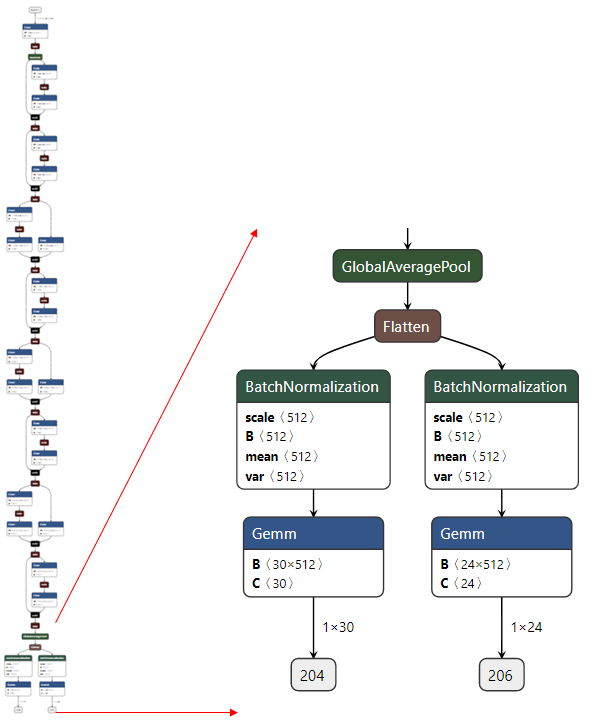

## 3. 模型訓練

### 3.1 將資料分成Train Set和Test Set



In [5]:
n_data = len(imagepaths)
val_size = 0.2
n_val = int(n_data * val_size)
n_train = n_data - n_val
np.random.seed(20210626)
randorder = np.random.permutation(n_data)


data_train = [imagepaths[randorder[tmp]]for tmp in range(n_train)]
bboxes_train = [bboxes[randorder[tmp]]for tmp in range(n_train)]
data_val = [imagepaths[randorder[tmp]]for tmp in range(n_train, n_data)]
bboxes_val = [bboxes[randorder[tmp]]for tmp in range(n_train, n_data)]
print('number of training data:{}'.format(len(data_train)))
print('number of validation data:{}'.format(len(data_val)))
print('number of total data:{}'.format(n_data))

number of training data:702
number of validation data:175
number of total data:877


<font size=3> 
我們觀察一下bboxes_train長怎麼樣子
</font>

In [6]:
print('第一張圖的boundary box:{}'.format(bboxes_train[0]))
print('第500張圖的boundary box:{}'.format(bboxes_train[500]))

第一張圖的boundary box:[[2], [[0, 198, 95, 307]]]
第500張圖的boundary box:[[2, 3], [[92, 194, 124, 226], [27, 294, 37, 313]]]


<font size=3> 
所以這個list塞的第一個位置是對應bbox的類別，第二個位置是bbox的座標

In [19]:
def count_object(bboxes):
    n_object=np.zeros(5)
    for boxs in bboxes:
        if len(boxs[0])>2:
            for box in boxs[0]:
                n_object[box]+=1
        else:
            n_object[boxs[0]]+=1
    print(n_object)
print('number of object in training set:')
count_object(bboxes_train)
print('number of object in validation set:')
count_object(bboxes_val)


number of object in training set:
[  0. 122. 560. 150.  71.]
number of object in validation set:
[  0.  34. 135.  47.  20.]


<font size=4 color='block'>**從count_object function可以看到**<br></font>
    
> Training set的資料分布: <br>
    >> 第1類的物件數為122個trafficlight。<br>
    >> 第2類的物件數為560個trafficlight。<br>
    >> 第3類的物件數為150個trafficlight。<br>
    >> 第4類的物件數為71個trafficlight。<br>
    
> Validation set的資料分布: <br>
    >> 第1類的物件數為34個trafficlight。<br>
    >> 第2類的物件數為135個trafficlight。<br>
    >> 第3類的物件數為47個trafficlight。<br>
    >> 第4類的物件數為20個trafficlight。<br>

Note: 物件對應表在前面定義在 labelmap = {'background':0, 'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 3}

<br>


### 3.2 開始定義Dataloader 與 data transforms</font>


<br>
<font size=3> 
所有的圖須先轉換成固定大小<br>
這邊我們先簡單寫個函數(resizewithbbox)將圖片的大小轉換為224*224，同時將對應的BBOX也需要跟著轉換。</font>
<br>


original image


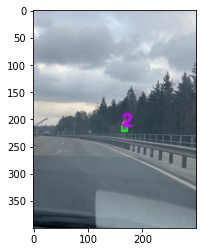

resized image


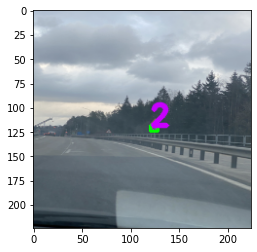

original image


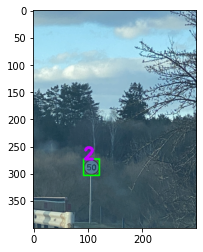

resized image


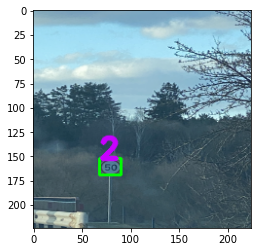

original image


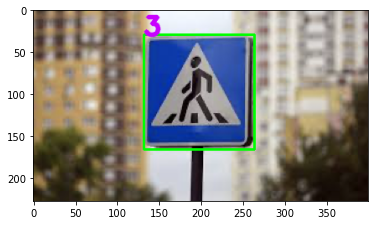

resized image


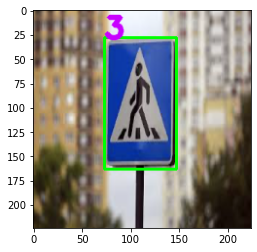

In [8]:
def resizewithbbox(image, bboxes, newsize=[224,224]):
    image = np.array(image)
    h,w,ch = image.shape
    new_w, new_h = newsize[0], newsize[1]
    scale_h, scale_w = new_h/h, new_w/w
    new_image = cv2.resize(image, (new_w, new_h))
    new_image = Image.fromarray(new_image)
    n = len(bboxes)
    new_bboxes = np.array(bboxes)
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]*scale_w 
        new_bboxes[:, 1] = new_bboxes[:, 1]*scale_h 
        new_bboxes[:, 2] = new_bboxes[:, 2]*scale_w 
        new_bboxes[:, 3] = new_bboxes[:, 3]*scale_h 
    return new_image, new_bboxes

for image_id in [20,100,10]:    
    image_path = data_train[image_id]
    bboxes = bboxes_train[image_id][1]
    labels = bboxes_train[image_id][0]

    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxes, labels,flag_bgr=0)

    print('resized image')
    new_img, new_bboxes = resizewithbbox(img, bboxes)
    imageplot=np.array(new_img.copy())
    plot_image_withbbox(imageplot, new_bboxes, labels,flag_bgr=0)




<br>
<font size=3> 

後續的圖片會利用torchvision的函數進行data transforms轉換 <br>
    1. 所有的圖片都需要用transforms.ToTensor，將8bits RGB PIL格式圖片(0-255)直接除上255轉換成(0-1)。<br>
    2. 利用transforms.Normalize將圖片進行正規化(Z-socre)，平均數和變異數採用ImageNet資料庫計算出來的值。<br>
    
針對訓練資料部分，將額外利用<br>
    transforms.ColorJitter(brightness=(0, 2), contrast=(
        0, 2), saturation=(0, 2), hue=(-0.3, 0.3))<br>
    進行資料擴增(data augumentation)。
</font>
<br>


original image


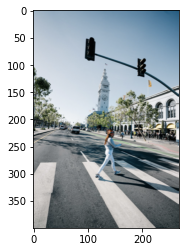

augumented image


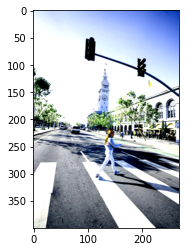

In [9]:
from torchvision import transforms
# image pre-process
process_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
)
transforms_dataaug = transforms.ColorJitter(brightness=(0.5, 1.5), 
                                            contrast=(0.5, 1.5), 
                                            saturation=(0.5, 1.5), 
                                            hue=(-18/255, 18/255))

###### Visualization for example #######
image_id = 200    
image_path = data_train[image_id]
img = Image.open(image_path, mode='r')
img = img.convert('RGB')
img_trans = transforms_dataaug(img)
print('original image')
plt.imshow(np.array(img))
plt.show()
print('augumented image')
plt.imshow(np.array(img_trans))
plt.show()


<br>
<font size=3> 
定義Dataloader <br><br>
1. 圖片讀進來後，採用RGB格式<br><br>
2. 圖片和BBOX需要resize到正方形(原因比較好操作後續計算)，此例會將圖片resize到(224x224)<br><br>
3. 如果是training phase則需要做Data Augumentation(我用is_transforms引入)，並且以30%的機率來進行。<br><br>
4. Ground Truth的BBOX座標會被正規化到0~1: <br>所以假設resize後的座標是$(56,112)$，則模型學習的目標會轉換成$(56/224,112/224)=(0.25, 0.5)$ <br><br>
</font>


In [10]:
class TrafficSignDataset(Dataset):
    def __init__(self, image_paths, bboxes, newsize=[224,224], is_transforms=False):
        self.is_transforms = is_transforms
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.newsize=newsize
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        bboxes = self.bboxes[idx]
        
        # 1.
        img = Image.open(path, mode='r')
        img = img.convert('RGB')
        bboxs = bboxes[1]
        bboxs_class = bboxes[0]
        
        # 2.
        img, bboxs = resizewithbbox(img, bboxs,newsize=self.newsize)
        
        # 3.
        if self.is_transforms:
            if np.random.random()<0.3:
                img = transforms_dataaug(img)
        img = process_transforms(img)
        bboxs_class= torch.tensor(bboxs_class)
        
        # 4.
        bboxs = torch.FloatTensor(bboxs/self.newsize[0])
        return img, bboxs, bboxs_class
    
    def collate_fn(self, batch):
        imgs = list()
        bboxes = list()
        bboxes_class = list()
        for b in batch:
            imgs.append(b[0])
            bboxes.append(b[1])
            bboxes_class.append(b[2])
        imgs=torch.stack(imgs,dim=0)
        return imgs, bboxes, bboxes_class
  

<br>
<font size=3> 
假設圖片為$x$，模型為$f$，偵測目標總共有C類，模型一共預測B個物件框
    
$$
\hat {BBox}_i = f(x), i=1,2,...,B  \\
\hat {BBox}_i = [(\hat x_{min}, \hat y_{min},\hat x_{max}, \hat y_{max}), (p_0, p_1,...,p_C)]
$$
<br>
Ground Truth的BBOX:
$$
BBox_i = [(x_{min}, y_{min},x_{max}, y_{max}), OneHotEncode(C)]
$$

<br>
    
**Loss設計目標:**
    
<br>
1. BBox座標逼近ground truth的座標，我這邊設計用L1 norm:<br>
$$
(\hat x_{min}, \hat y_{min},\hat x_{max}, \hat y_{max}) \to (x_{min}, y_{min},x_{max}, y_{max}) \\
loss(box)=|\hat x_{min} - x_{min}|+|\hat y_{min} - y_{min}|+|\hat x_{max} - x_{max}|+|\hat y_{max} - y_{max}|
$$    
2. BBox分類採Cross Entropy:<br>
$$
loss(CE)=\sum_{i}^{B} CrossEntropy(BBox_i, C)
$$

學習目標:
$$
loss = loss(box) + 2 * loss(CE)
$$
    
見 "class LOSS_OD"

</font>


In [11]:
class LOSS_OD(nn.Module):
    def __init__(self, n_bbox, n_class):
        super(LOSS_OD,self).__init__()
        self.n_bbox = n_bbox
        self.n_class = n_class
        self.Softmax= nn.Softmax(dim=2)
    def forward(self,preds_bb, preds_class, bboxs, bboxs_class):
        n_bbox = self.n_bbox
        n_class = self.n_class
        
        batch_size = preds_bb.size(0)
        
        preds_class = torch.reshape(preds_class,(batch_size, n_bbox, n_class+1)) # (batch, n_bbox, n_class+1)
        preds_class = self.Softmax(preds_class)
        preds_bb = torch.reshape(preds_bb,(batch_size, n_bbox, 4)) # (batch, n_bbox, 4)
        
#         true_locs = torch.zeros((batch_size, n_bbox, 4),dtype=torch.float).to(device) # (batch, n_bbox, 4)
#         true_classes = torch.zeros((batch_size, n_bbox),dtype=torch.long).to(device) # (batch, n_bbox)

        loss_conf,  loss_locs = 0,0
        for b in range(batch_size):
            sub_bboxs = bboxs[b]
            sub_bboxs_class = bboxs_class[b]
            n_object = sub_bboxs.size(0)
            if n_object==0:
                continue        
            pred_class=preds_class[b,0:n_object,:]
            pred_bb=preds_bb[b,0:n_object,:]
            
            loss_conf +=  F.cross_entropy(pred_class.view(-1,n_class+1),sub_bboxs_class , reduction="sum")
            loss_locs += F.l1_loss(pred_bb, sub_bboxs, reduction="sum")
#             true_locs[b][0:n_object]=sub_bboxs
#             true_classes[b][0:n_object]=sub_bboxs_class
#         loss_locs = F.l1_loss(preds_bb, true_locs, reduction="mean")
#         loss_conf = F.cross_entropy(preds_class.view(-1,n_class+1), true_classes.view(-1) , reduction="sum")
#         print(loss_locs)
        return loss_locs + 2*loss_conf

In [12]:
use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
epochs = 100
n_class = 4
n_bbox = 8 # 模型要最多能預測多少物件
lr = 0.0002
batch_size = 8

# training -> is_transforms=True
# validation/test -> is_transforms=False
dataset_train = TrafficSignDataset(data_train, bboxes_train, newsize=[224,224], is_transforms=True) 
dataset_val   = TrafficSignDataset(data_val,   bboxes_val,   newsize=[224,224], is_transforms=False) 
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=dataset_train.collate_fn )
valid_dl = DataLoader(dataset_val  , batch_size=batch_size, shuffle=True, collate_fn=dataset_val.collate_fn)

model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)

loss_od = LOSS_OD(n_bbox=n_bbox, n_class=n_class)

# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    

In [13]:
import time
loss_train_log, loss_val_log=[],[]
loss_all_train_log, loss_all_val_log=[],[]
for e in range(epochs):
    
    # training step
    model.train()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in train_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        preds_class, preds_bb = model(imgs)
        loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len_batch
        sum_loss += loss.item()
        loss_all_train_log.append(loss.item())
    time_train =  time.time()-st
    train_loss = sum_loss / total
    loss_train_log.append(train_loss)
    
    # eval
    model.eval()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in valid_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        with torch.no_grad():
            preds_class, preds_bb = model(imgs)
            loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
            
        total += len_batch
        sum_loss += loss.item()
        loss_all_val_log.append(loss.item())
    time_val =  (time.time()-st) 
    eval_loss = sum_loss / total
    loss_val_log.append(eval_loss)
    if e % 5 == 0:
        print("Epoch[{}/{}], lr={:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, train_time:{:.4f},val_time:{:.4f}".format(e+1,
                                                                                                               epochs,
                                                                                                               scheduler.get_last_lr()[0],
                                                                                                               train_loss, 
                                                                                                               eval_loss,
                                                                                                               time_train,
                                                                                                               time_val))
    scheduler.step()
    

Epoch[1/100], lr=0.000200, train_loss: 7.3159, val_loss: 7.0166, train_time:11.6820,val_time:1.5914
Epoch[6/100], lr=0.000200, train_loss: 3.9871, val_loss: 4.7750, train_time:9.7536,val_time:1.4338
Epoch[11/100], lr=0.000100, train_loss: 3.5515, val_loss: 3.8732, train_time:10.0524,val_time:1.9363
Epoch[16/100], lr=0.000100, train_loss: 3.3796, val_loss: 3.8612, train_time:10.4915,val_time:1.7182
Epoch[21/100], lr=0.000050, train_loss: 3.2659, val_loss: 3.7563, train_time:9.5565,val_time:1.4610
Epoch[26/100], lr=0.000050, train_loss: 3.2061, val_loss: 3.6762, train_time:10.3482,val_time:1.5637
Epoch[31/100], lr=0.000025, train_loss: 3.1491, val_loss: 3.6305, train_time:9.4413,val_time:1.4551
Epoch[36/100], lr=0.000025, train_loss: 3.1048, val_loss: 3.6473, train_time:9.3001,val_time:1.4275
Epoch[41/100], lr=0.000013, train_loss: 3.0749, val_loss: 3.6745, train_time:9.4914,val_time:1.4722
Epoch[46/100], lr=0.000013, train_loss: 3.1045, val_loss: 3.6189, train_time:9.3648,val_time:1.444

觀察一下loss變化

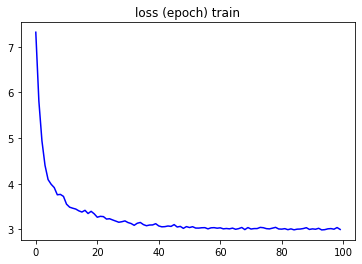

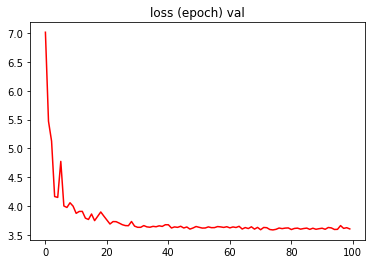

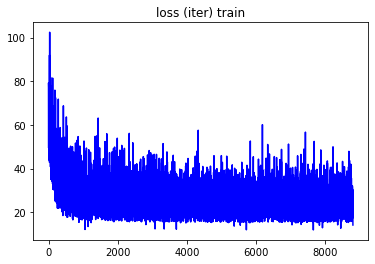

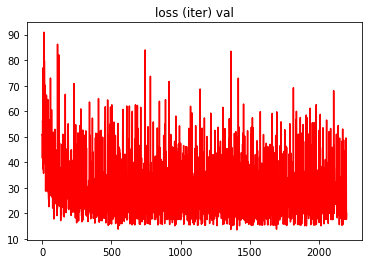

In [14]:
plt.plot(loss_train_log[:],'b')
plt.title('loss (epoch) train')
plt.show()

plt.plot(loss_val_log[:],'r')
plt.title('loss (epoch) val')
plt.show()

plt.plot(loss_all_train_log[:],'b')
plt.title('loss (iter) train')
plt.show()

plt.plot(loss_all_val_log[:],'r')
plt.title('loss (iter) val')
plt.show()


In [15]:
checkpoint={}
checkpoint['loss_train_log']=loss_train_log
checkpoint['loss_val_log']=loss_val_log
checkpoint['loss_all_train_log']=loss_all_train_log
checkpoint['loss_all_val_log']=loss_all_val_log
checkpoint['model_dict'] = model.state_dict()
torch.save(checkpoint, 'Model_OD_trafficsign.pth')
print('Model saved.')

Model saved.


## 4. 模型測試

In [16]:
# load model
use_cuda = 1
n_class = 4
n_bbox = 8
device = torch.device("cuda:0" if use_cuda else "cpu")
checkpoint = torch.load('Model_OD_trafficsign.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [17]:
# load model
use_cuda = 1
n_class = 4
n_bbox = 8
device = torch.device("cuda:0" if use_cuda else "cpu")
checkpoint = torch.load('Model_OD_trafficsign.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

Inference Image:dataset\stopsign\images\road456.png
original image


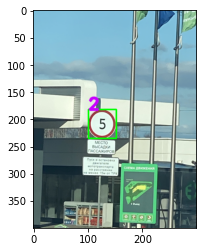

Detection image


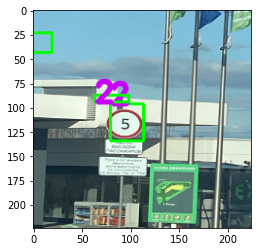

Inference Image:dataset\stopsign\images\road505.png
original image


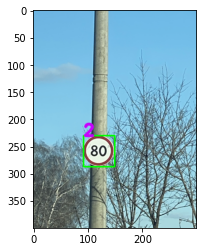

Detection image


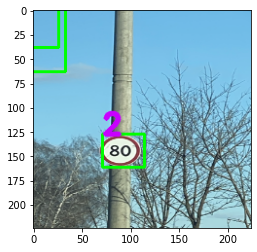

Inference Image:dataset\stopsign\images\road358.png
original image


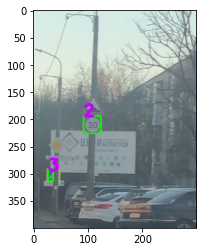

Detection image


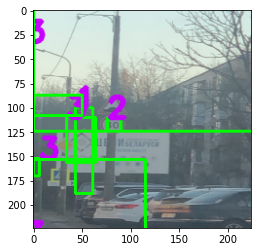

In [18]:
for image_id in [2,5,500]:
    image_path = data_train[image_id]
    bboxs = bboxes_train[image_id][1]
    bboxs_class = bboxes_train[image_id][0]
    # image_path = data_val[image_id]
    # bboxs = bboxes_val[image_id][1]
    # bboxs_class = bboxes_val[image_id][0]
    print('Inference Image:{}'.format(image_path))
    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxs, bboxs_class, flag_bgr=0)


    print('Detection image')
    img, bboxs = resizewithbbox(img, bboxs,newsize=[224,224])
    resize_img=np.array(img.copy())
    img = process_transforms(img)
    img = img.unsqueeze(dim=0)

    model.eval()
    with torch.no_grad():
        preds_class, preds_bb = model(img.to(device))


    preds_bb = preds_bb[0]
    preds_bb = torch.reshape(preds_bb,(n_bbox, 4)) # (batch, n_bbox, 4)
    preds_bb = preds_bb.detach().cpu().numpy()
    preds_bb = preds_bb*224



    preds_class = preds_class[0]
    preds_class = torch.reshape(preds_class,(n_bbox, n_class+1)) # ( n_bbox, n_class+1)
    preds_class = nn.Softmax(dim=1)(preds_class)
    v, ind = torch.max(preds_class,dim=1)
    v = v.detach().cpu().numpy()
    ind = ind.detach().cpu().numpy()
    p_bbox, final_bbox=[],[]
    final_label=[]
    for i,tmp_ind in enumerate(ind):
        if tmp_ind > 0:
            p_bbox.append(preds_class[i,tmp_ind])
            final_bbox.append(preds_bb[i,:])
            final_label.append(tmp_ind)
    plot_image_withbbox(resize_img, final_bbox,final_label, flag_bgr=0)


# Note: 物件對應表在前面定義在 labelmap = {'background':0, 'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 3}

 

# 觀察得現象
<font size=4>
1. 學習的時候，我們設定物件偵測需要偵測有B個物件<br>
    B如果設定太大，則模型會超大，也不容易訓練。<br>
    我們的範例只設定8個，就已經多預測一堆了。<br><br>
2. 最後在偵測物件框的時候，每一個預測框應該要學習偵測哪個物件，造成混亂學習，所以會學不起來。
    
   
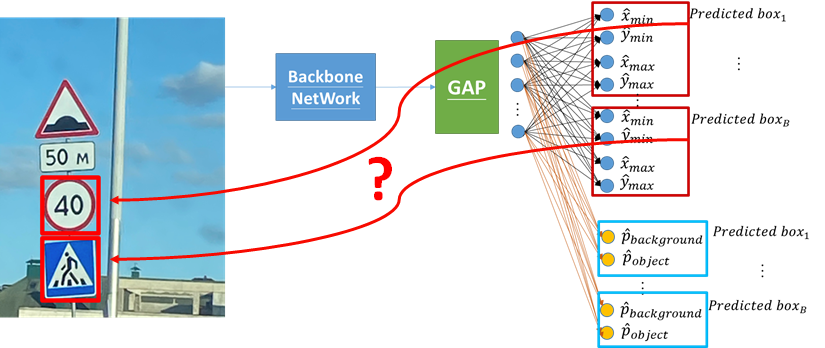
    
所以很不準，我們下一份資料介紹YOLOv1怎麼避掉這樣的問題。